In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torchvision
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
torch.manual_seed(SEED)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)

val_size = int(0.2 * len(dataset))
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(SEED))

BATCH_SIZE = 128
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"Train samples: {len(train_ds)} | Val samples: {len(val_ds)}")


Train samples: 48000 | Val samples: 12000


In [7]:
# VAE
class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super().__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        self.flatten_dim = 64 * 7 * 7

        self.fc_mu = nn.Linear(self.flatten_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_dim, latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim, self.flatten_dim)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        encoded = self.encoder(x)
        mu = self.fc_mu(encoded)
        logvar = self.fc_logvar(encoded)
        z = self.reparameterize(mu, logvar)
        decoded_input = self.decoder_input(z)
        x_recon = self.decoder(decoded_input)
        return x_recon, mu, logvar
    
    def decode(self, z):
        decoded_input = self.decoder_input(z)
        x_recon = self.decoder(decoded_input)
        return x_recon

In [8]:
# Loss
def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kl_loss

In [9]:
# Training
def train_vae(model, train_loader, val_loader, device, epochs=10):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for x, _ in train_loader:
            x = x.to(device)
            recon_x, mu, logvar = model(x)
            loss = vae_loss(recon_x, x, mu, logvar)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, _ in val_loader:
                x = x.to(device)
                recon_x, mu, logvar = model(x)
                val_loss += vae_loss(recon_x, x, mu, logvar).item()

        print(f"Epoch {epoch+1} - Train Loss: {train_loss:.2f} - Val Loss: {val_loss:.2f}")

In [10]:
# Show results
def show_result_vae(model, loader, device, n=8):
    model.eval()
    with torch.no_grad():
        images, _ = next(iter(loader))
        images = images[:n].to(device)
        recon_images, _, _ = model(images)
        recon_images = recon_images.cpu()

    comparison = torch.cat([images.cpu(), recon_images])
    grid = torchvision.utils.make_grid(comparison, nrow=n, normalize=True)
    plt.figure(figsize=(20, 4))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.title("org vs recon")
    plt.show()

In [11]:
# Sample
def generate_images(model, device, n=8):
    model.eval()
    with torch.no_grad():
        z = torch.randn(n, model.latent_dim).to(device)
        z = model.decoder_input(z)
        gen_images = model.decoder(z).cpu()

    grid = torchvision.utils.make_grid(gen_images, nrow=n, normalize=True)
    plt.figure(figsize=(20, 4))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.title("Generated Images")
    plt.show()

In [ ]:
vae_model = VAE(latent_dim=2)
train_vae(vae_model, train_loader, val_loader, device, epochs=10)

Epoch 1 - Train Loss: 11578468.83 - Val Loss: 2131905.12
Epoch 2 - Train Loss: 8271875.78 - Val Loss: 2004056.25
Epoch 3 - Train Loss: 7899969.54 - Val Loss: 1943480.18
Epoch 4 - Train Loss: 7691151.93 - Val Loss: 1901036.30
Epoch 5 - Train Loss: 7555351.15 - Val Loss: 1878513.44
Epoch 6 - Train Loss: 7452522.72 - Val Loss: 1852215.81
Epoch 7 - Train Loss: 7361650.91 - Val Loss: 1834772.85
Epoch 8 - Train Loss: 7280160.58 - Val Loss: 1819177.13
Epoch 9 - Train Loss: 7207081.42 - Val Loss: 1803899.72
Epoch 10 - Train Loss: 7146124.96 - Val Loss: 1787232.21


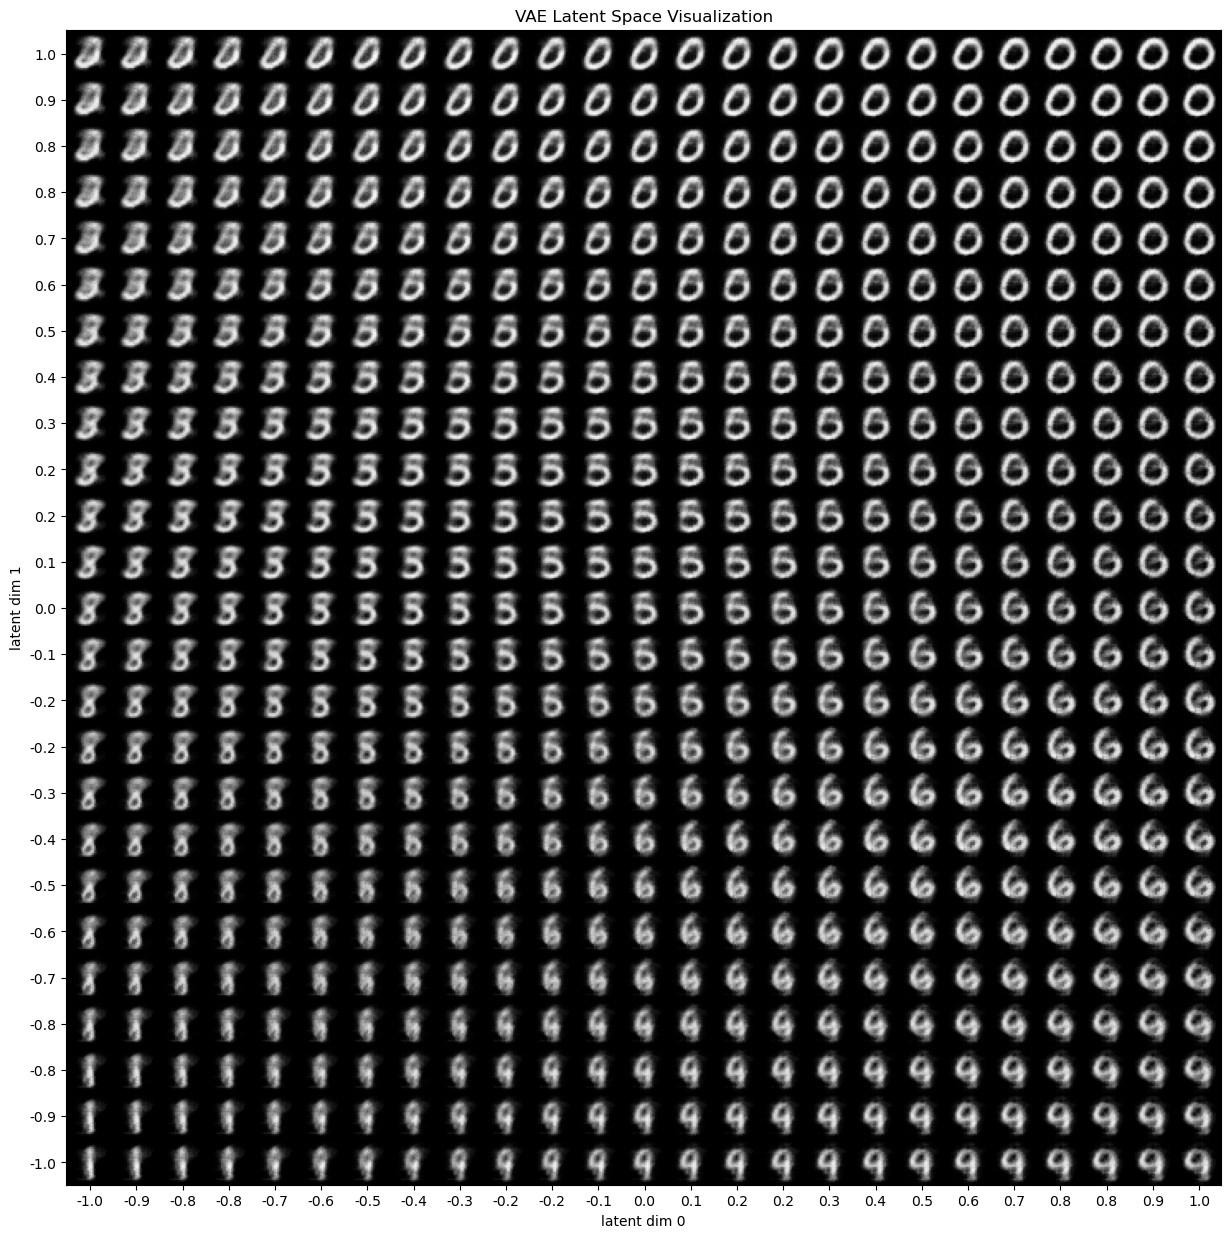

In [34]:
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def plot_latent_space(model, scale=1.0, n=25, digit_size=28, figsize=15, device='cpu'):
    figure = np.zeros((digit_size * n, digit_size * n))
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    model.to(device)
    model.eval()
    with torch.no_grad():
        for i, yi in enumerate(grid_y):
            for j, xi in enumerate(grid_x):
                z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
                decoded_input = model.decoder_input(z_sample)
                x_decoded = model.decoder(decoded_input)
                digit = x_decoded[0].cpu().reshape(digit_size, digit_size)
                figure[i * digit_size : (i + 1) * digit_size,
                       j * digit_size : (j + 1) * digit_size] = digit.numpy()

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("latent dim 0")
    plt.ylabel("latent dim 1")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
plot_latent_space(vae_model, device=device)


c:\Users\jastr\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


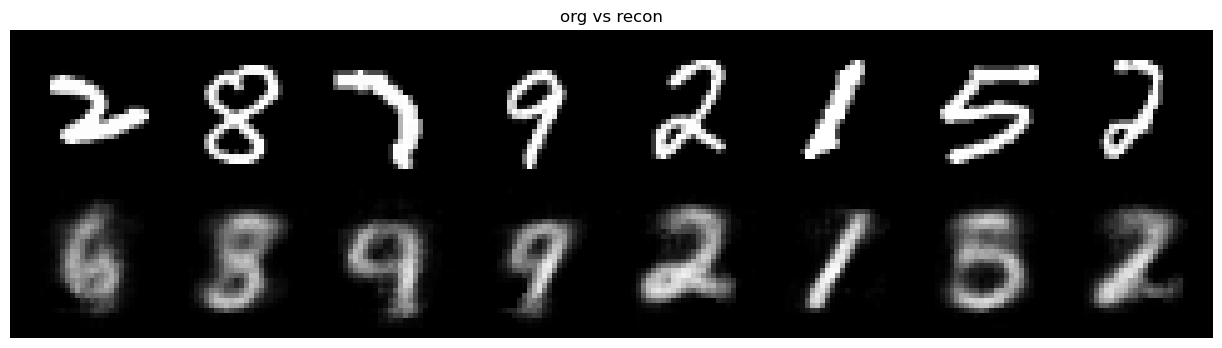

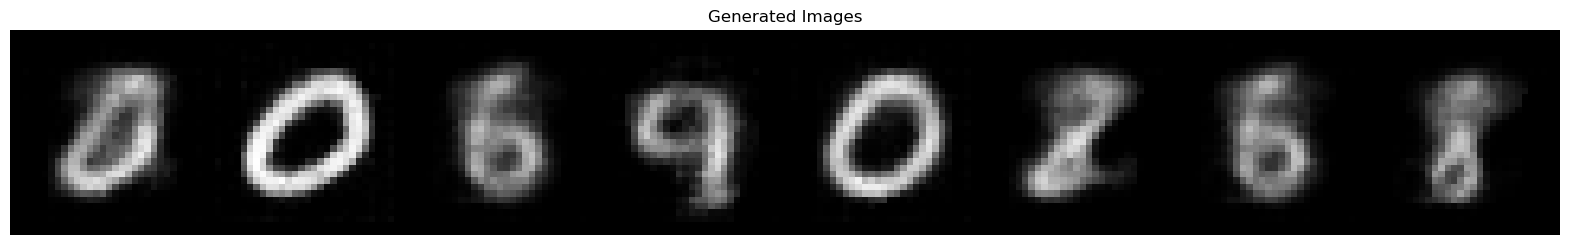

In [ ]:
# Visualize Results
show_result_vae(vae_model, val_loader, device)
generate_images(vae_model, device)